In [1]:
import os
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend([os.path.abspath('..')])

Python 3.10.12 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 19:01:18) [MSC v.1916 64 bit (AMD64)] on win32


In [2]:
import warnings
from pathlib import Path

import bids
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds
from nilearn.maskers import NiftiLabelsMasker
from scipy.io import loadmat

from denoising.helpers import *

warnings.filterwarnings("ignore", category=FutureWarning)


user_path = os.path.expanduser("~")

In [3]:
# load dataset
# derivatives in IHB are zipped, it failed to load folder as is
derivatives_path = r"C:\Users\user\Desktop\open_close_001\derivatives"

layout = bids.BIDSLayout(Path(derivatives_path).as_posix(), 
                         validate=False, config=['bids','derivatives'])

layout

BIDS Layout: ...top\open_close_001\derivatives | Subjects: 2 | Sessions: 0 | Runs: 4

In [4]:
# load atlas
atlas_path = os.path.join(user_path, 
                          Path(r'YandexDisk\IHB\Projects\OpenCloseFMRI\data\atlas\HCPex_atlas.nii').as_posix())
atlas_filename = nib.load(Path(atlas_path).as_posix())

# atlas look up table
roi_table_path = os.path.join(user_path, 
                              Path(r'YandexDisk\IHB\Projects\OpenCloseFMRI\data\atlas\HCPex_sorted_v2_networks_names.xlsx').as_posix())
roi = pd.read_excel(Path(roi_table_path).as_posix(), index_col='Index')

# roi labels in original order
roi_labels = roi.sort_values(by='ID').Label.values
roi.head()

Unnamed: 0   ID                    Label Cortical Division    R    G  \
Index                                                                         
0               0    1  Primary_Visual_Cortex_L    Primary_Visual  208  216   
1               1  181  Primary_Visual_Cortex_R    Primary_Visual  208  216   
2               2    2     Second_Visual_Area_L      Early_Visual  231   50   
3               3  182     Second_Visual_Area_R      Early_Visual  231   50   
4               4    3      Third_Visual_Area_L      Early_Visual   33   58   

         B       X       Y      Z  network network_label  
Index                                                     
0      117 -10.078 -84.159  1.759        1       Visual1  
1      117  12.231 -80.644  4.101        1       Visual1  
2      224 -12.044 -82.059  4.029        2       Visual2  
3      224  12.367 -78.138  5.714        2       Visual2  
4      133 -16.607 -84.793  7.259        2       Visual2

In [11]:
layout.files

{'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001.html': <BIDSFile filename='C:\Users\user\Desktop\open_close_001\derivatives\sub-001.html'>,
 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\anat\\001_struct.nii': <BIDSImageFile filename='C:\Users\user\Desktop\open_close_001\derivatives\sub-001\anat\001_struct.nii'>,
 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\anat\\c001_struct.nii': <BIDSImageFile filename='C:\Users\user\Desktop\open_close_001\derivatives\sub-001\anat\c001_struct.nii'>,
 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\anat\\c001_struct_seg8.mat': <BIDSFile filename='C:\Users\user\Desktop\open_close_001\derivatives\sub-001\anat\c001_struct_seg8.mat'>,
 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\anat\\c1c001_struct.nii': <BIDSImageFile filename='C:\Users\user\Desktop\open_close_001\derivatives\sub-001\anat\c1c001_struct.nii'>,
 'C:\\Users\\user\\Desktop\\open_close_001\\derivati

In [5]:
# paths for functional files of 1st subject

sub = ['001', '002']
func_files = layout.get(subject=sub,
                        datatype='func', task='rest',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                        return_type='file')

print(func_files)

close_img = func_files[0]
open_img = func_files[1]

['C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\func\\sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\func\\sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-002\\func\\sub-002_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-002\\func\\sub-002_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


In [31]:
#mask_files = layout.get(subject=sub, datatype='func', suffix='mask', extension='.nii.gz', return_type='file')

### Denoising

In [6]:
confound_files = layout.get(subject=sub,
                            datatype='func', task='rest',
                            desc='confounds',
                            extension="tsv",
                            return_type='file')

close_outliers = pd.read_csv(confound_files[0], sep='\t')
open_outliers  = pd.read_csv(confound_files[1], sep='\t')
close_outliers.head()

global_signal  global_signal_derivative1  global_signal_power2  \
0     852.304602                        NaN         726423.134938   
1     852.647065                   0.342463         727007.017279   
2     851.333827                  -1.313238         724769.285606   
3     850.819642                  -0.514185         723894.063696   
4     848.442555                  -2.377088         719854.768356   

   global_signal_derivative1_power2          csf  csf_derivative1  \
0                               NaN  1630.212847              NaN   
1                          0.117281  1627.423782        -2.789065   
2                          1.724593  1628.462576         1.038794   
3                          0.264386  1635.027641         6.565065   
4                          5.650546  1637.959867         2.932226   

   csf_derivative1_power2    csf_power2  white_matter  \
0                     NaN  2.657594e+06    934.802824   
1                7.778886  2.648508e+06    931.277672   
2                1.079093  2.651890e+06    934.648168   
3               43.100082  2.673315e+06    933.676955   
4                8.597947  2.682913e+06    934.386624   

   white_matter_derivative1  ...  rot_x_power2         rot_y  \
0                       NaN  ...  6.399635e-08 -0.000000e+00   
1                 -3.525152  ...  6.568827e-07 -1.211790e-23   
2                  3.370496  ...  3.282580e-09 -0.000000e+00   
3                 -0.971213  ...  1.533294e-07 -0.000000e+00   
4                  0.709668  ...  1.309445e-06  4.397500e-04   

   rot_y_derivative1  rot_y_power2  rot_y_derivative1_power2     rot_z  \
0                NaN  0.000000e+00                       NaN  0.000173   
1      -1.211790e-23  1.468435e-46              1.468435e-46  0.000112   
2       1.211790e-23  0.000000e+00              1.468435e-46  0.000090   
3       0.000000e+00  0.000000e+00              0.000000e+00 -0.000098   
4       4.397500e-04  1.933801e-07              1.933801e-07 -0.000264   

   rot_z_derivative1  rot_z_power2  rot_z_derivative1_power2  motion_outlier00  
0                NaN  2.985431e-08                       NaN               0.0  
1          -0.000061  1.249209e-08              3.722952e-09               0.0  
2          -0.000022  8.023555e-09              4.925603e-10               0.0  
3          -0.000188  9.699571e-09              3.536683e-08               0.0  
4          -0.000166  6.970709e-08              2.740170e-08               0.0  

[5 rows x 138 columns]

In [17]:
strategy_1 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'full',
                      'compcor': 'anat_combined',
                      'n_compcor': 10}

close_conf, _ = load_confounds(func_files[:2], **strategy_1)

In [14]:
(close_conf, open_conf), sample_mask = load_confounds(
    func_files[0],
    strategy=['motion', 'compcor', 'high_pass'], # copcor option requires high_pass
    motion="full",                               # 24 parameters
    compcor='anat_combined', 
    n_compcor=10                                 # 'full' for compcor50
    )

print("The shape of the confounds matrix is:", close_conf.shape)
print(close_conf.columns)

TypeError: list indices must be integers or slices, not list

If your analysis includes separate high-pass filtering, do not include cosine_XX regressors in your design matrix.

fMRIPrep does high-pass filtering before running anatomical or temporal CompCor. Therefore, when using CompCor regressors, the corresponding cosine_XX regressors should also be included in the design matrix.

In [18]:
type(close_conf)

list

In [16]:
df = close_conf
close_conf = df.loc[:,~df.columns.str.startswith('cosine')]

In [11]:
close_conf[0].drop(['cosine00', 'cosine01', 'cosine02'], axis=1, inplace=True)
#open_conf.drop(['cosine00', 'cosine01', 'cosine02'], axis=1, inplace=True)

In [12]:
close_conf[0]

a_comp_cor_00  a_comp_cor_01  a_comp_cor_02  a_comp_cor_03  \
0         0.101723       0.229325      -0.059259       0.029732   
1        -0.026666       0.183151      -0.135998       0.025896   
2         0.177307       0.064106      -0.091058      -0.137753   
3         0.167083       0.112978      -0.138759      -0.033274   
4         0.199625      -0.072013       0.003466       0.205204   
..             ...            ...            ...            ...   
115      -0.034761      -0.053757      -0.137640       0.335201   
116       0.048936      -0.046956      -0.087517       0.069881   
117      -0.036844      -0.021387       0.033652      -0.205279   
118       0.135291      -0.106156      -0.172457      -0.045156   
119       0.048819      -0.119118      -0.082041       0.011193   

     a_comp_cor_04  a_comp_cor_05  a_comp_cor_06  a_comp_cor_07  \
0        -0.041957       0.010924       0.017046      -0.063458   
1         0.061039      -0.083719      -0.066770       0.018875   
2        -0.125530       0.042215      -0.004992      -0.098986   
3        -0.091033      -0.053797      -0.022208       0.071817   
4        -0.040921       0.004343      -0.016563       0.051617   
..             ...            ...            ...            ...   
115      -0.113025       0.074817       0.074019       0.108804   
116       0.083363      -0.155058      -0.092664       0.132485   
117      -0.142782      -0.136678      -0.000471       0.038693   
118      -0.043238      -0.010745      -0.101173       0.141712   
119      -0.062704       0.000641      -0.125649       0.103115   

     a_comp_cor_08  a_comp_cor_09  ...  trans_x_derivative1_power2  \
0         0.182973      -0.012358  ...                   -0.000352   
1        -0.056648      -0.022796  ...                   -0.000352   
2         0.028144      -0.038541  ...                   -0.000352   
3        -0.013941       0.012170  ...                   -0.000352   
4        -0.131883       0.042036  ...                   -0.000283   
..             ...            ...  ...                         ...   
115      -0.053670       0.091448  ...                   -0.000171   
116      -0.039599       0.013590  ...                    0.001263   
117       0.227429      -0.077484  ...                   -0.000009   
118       0.118957      -0.067964  ...                   -0.000352   
119      -0.053274      -0.002668  ...                    0.000702   

     trans_x_power2   trans_y  trans_y_derivative1  \
0         -0.000200 -0.019863             0.022466   
1         -0.000200  0.002964             0.022466   
2         -0.000200  0.004130             0.000806   
3         -0.000200  0.004833             0.000343   
4         -0.000131 -0.019695            -0.024889   
..              ...       ...                  ...   
115        0.000024 -0.003915            -0.000316   
116        0.000435 -0.008120            -0.004566   
117       -0.000156  0.011910             0.019670   
118       -0.000154  0.005287            -0.006983   
119        0.000457  0.000554            -0.005093   

     trans_y_derivative1_power2  trans_y_power2   trans_z  \
0                      0.000353       -0.000142  0.003737   
1                      0.000353       -0.000215 -0.012730   
2                     -0.000166       -0.000191  0.015649   
3                     -0.000167       -0.000175  0.011820   
4                      0.000434       -0.000146  0.067726   
..                          ...             ...       ...   
115                   -0.000168       -0.000303 -0.013636   
116                   -0.000150       -0.000310 -0.026740   
117                    0.000233        0.000040 -0.011151   
118                   -0.000124       -0.000164  0.005558   
119                   -0.000145       -0.000257 -0.000771   

     trans_z_derivative1  trans_z_derivative1_power2  trans_z_power2  
0              -0.016293                   -0.000372       -0.000500  
1              -0.016293      

### Extract time series

In [9]:
masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    labels=roi_labels, 
    memory="nilearn_cache",
    verbose=2,
    standardize='zscore_sample',
    detrend=True,
    # if not using cosineXX confounds
    #high_pass=0.008,
    #low_pass=0.09, 
    #t_r=2.5,
    resampling_target='labels'
    )

# about 15 minutes to compute both
close_ts = masker.fit_transform(close_img, confounds=close_conf)
open_ts  = masker.fit_transform(open_img, confounds=open_conf)

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image('C:\Users\user\YandexDisk\IHB\Projects\OpenCloseFMRI\data\atlas\HCPex_atlas.nii')
[Memory]0.0s, 0.0min    : Loading _filter_and_extract...
[NiftiLabelsMasker.wrapped] loading data from Nifti1Image('C:\Users\user\YandexDisk\IHB\Projects\OpenCloseFMRI\data\atlas\HCPex_atlas.nii')
[Memory]0.2s, 0.0min    : Loading _filter_and_extract...


In [10]:
open_ts.shape

(120, 426)

In [12]:
df = pd.DataFrame(open_ts, columns=roi_labels)

In [19]:
df.to_csv('../test.csv', index=False)

In [20]:
pd.read_csv('../test.csv')

Primary_Visual_Cortex_L  Second_Visual_Area_L  Third_Visual_Area_L  \
0                   1.533373              2.006644             2.067787   
1                   1.124619              0.479351            -0.055627   
2                  -0.733994             -0.019126            -0.116170   
3                  -0.547088             -0.723993             0.098735   
4                  -0.416819              0.200523            -1.400257   
..                       ...                   ...                  ...   
115                -0.040524              0.276707             0.303936   
116                 0.498715              0.900819             0.053409   
117                 0.245083              0.314203            -0.522370   
118                -0.907303             -0.858954             0.179991   
119                 1.038551              1.612788             0.694223   

     Fourth_Visual_Area_L  IntraParietal_Sulcus_Area_1_L  Area_V3A_L  \
0                1.385755                      -0.663747    1.320332   
1                1.190000                      -1.566967    1.006473   
2               -0.496951                      -1.295595    0.622909   
3                0.743404                      -1.326689   -1.203869   
4               -0.794118                       0.263873    0.342270   
..                    ...                            ...         ...   
115              0.769260                       0.308837    0.342398   
116             -0.111677                      -0.513273    1.398210   
117              0.745089                      -1.744962    0.312176   
118              0.002533                       0.296545   -0.263018   
119              0.098587                      -1.517439    0.529714   

     Area_V3B_L  Sixth_Visual_Area_L  Area_V6A_L  Seventh_Visual_Area_L  ...  \
0     -1.402817            -0.071597    1.231437               0.467806  ...   
1      0.024861            -0.596644   -0.391822              -0.267175  ...   
2     -0.417596            -0.651514   -0.841009              -0.137611  ...   
3      1.468966             0.630914   -0.034735              -0.525370  ...   
4      1.087362             0.251961    0.925908               0.499691  ...   
..          ...                  ...         ...                    ...  ...   
115    1.570739            -0.169265    0.254679               1.158694  ...   
116   -1.835527            -0.073810   -0.940569               0.861853  ...   
117   -1.367598            -0.660162   -0.314328               0.314470  ...   
118    0.398062            -0.513104    1.223858              -0.577026  ...   
119   -0.010525             0.436104   -0.179743              -0.361961  ...   

     Nucleus_Accumbens_R  Globus_pallidus_externalis_R  \
0              -0.302984                     -0.388644   
1               0.331544                     -1.194035   
2              -0.406100                     -0.834706   
3               1.027113                      0.226873   
4              -0.973860                     -0.959735   
..                   ...                           ...   
115             0.260810                      0.316631   
116             0.972877                     -0.683209   
117             1.928802                      0.396535   
118            -2.895284                     -1.315943   
119             0.368918                     -0.621241   

     Globus_pallidus_internalis_R  Amygdala_R  \
0                       -1.111818   -0.431893   
1                        1.335455   -0.927595   
2                        0.579195    0.535612   
3                       -0.482665   -0.403152   
4                        1.269047   -0.698575   
..                            ...         ...   
115                     -1.276183   -0.855332   
116                     -0.590298    1.128023   
117                      0.698386   -1.039404   
118                      1.584073    0.363005   
119                     -0.106389   -0.806

In [10]:
correlation_measure = ConnectivityMeasure(kind="correlation")
correlation_matrix = correlation_measure.fit_transform([close_ts, open_ts])
np.fill_diagonal(correlation_matrix[0], 0)
np.fill_diagonal(correlation_matrix[1], 0)

c:\ProgramData\Anaconda3\envs\nilearn\lib\site-packages\nilearn\plotting\matrix_plotting.py:293: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


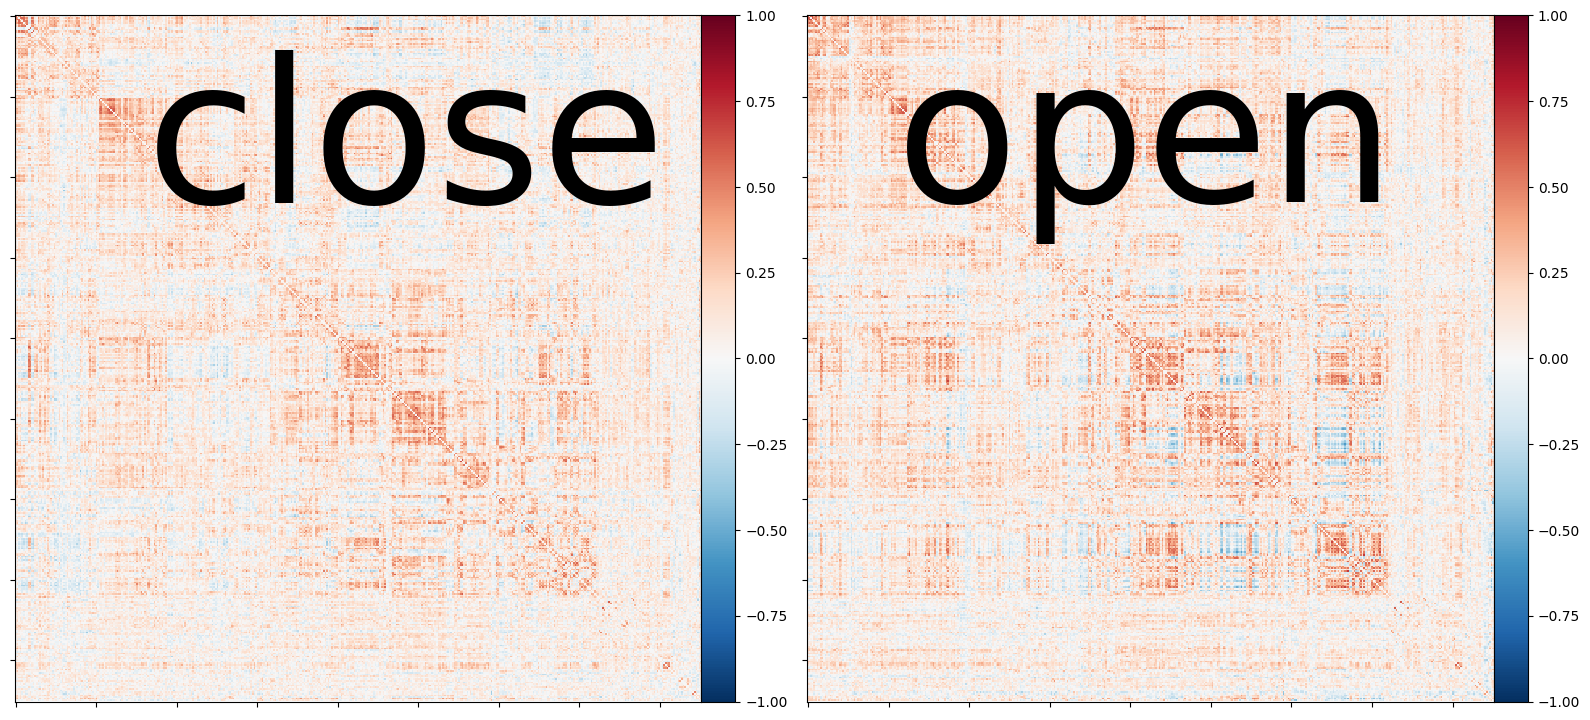

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plotting.plot_matrix(
    reorder_matrix(correlation_matrix[0], roi.ID-1),
    labels=None,
    vmax=1,
    vmin=-1,
    title="close",
    reorder=False, axes=ax1)

plotting.plot_matrix(
    reorder_matrix(correlation_matrix[1], roi.ID-1),
    labels=None,
    vmax=1,
    vmin=-1,
    title="open ", 
    reorder=False, axes=ax2);


### QC-FC

### Load Conn outputs

In [12]:
mat_path = os.path.join(user_path, 
                        Path(r'YandexDisk\IHB\Projects\OpenCloseFMRI\data\connToolbox\ROI_Subject001_Condition000.mat').as_posix())

ts_conn = loadmat(Path(mat_path).as_posix())


ts_close_conn = np.zeros((426, 120))
ts_open_conn = np.zeros((426, 120))
# first 3 ts are for conn's default labels (ie CSF and white matter)
# conn store outputs for 2 sessions in one file, first for close, then for open
for i in range(3, 429):
    ts_close_conn[i-3] = ts_conn['data'][0][i].reshape((240))[:120]
    ts_open_conn[i-3]  = ts_conn['data'][0][i].reshape((240))[120:]


In [13]:
z_path_c = os.path.join(user_path, 
                        Path(r'YandexDisk\IHB\Projects\OpenCloseFMRI\data\connToolbox\resultsROI_Subject001_Condition001.mat').as_posix())
z_path_o = os.path.join(user_path, 
                        Path(r'YandexDisk\IHB\Projects\OpenCloseFMRI\data\connToolbox\resultsROI_Subject001_Condition002.mat').as_posix())

close_z = loadmat(z_path_c)['Z']
open_z  = loadmat(z_path_o)['Z']

np.fill_diagonal(close_z, 0)
np.fill_diagonal(open_z, 0)

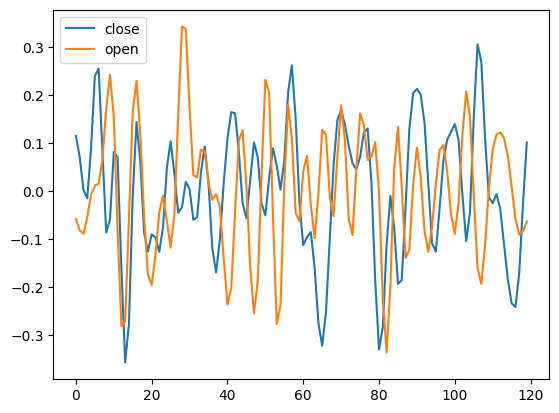

In [14]:
plt.plot(ts_close_conn[0], label='close')
plt.plot(ts_open_conn[0], label='open')
plt.legend();

### Comparison

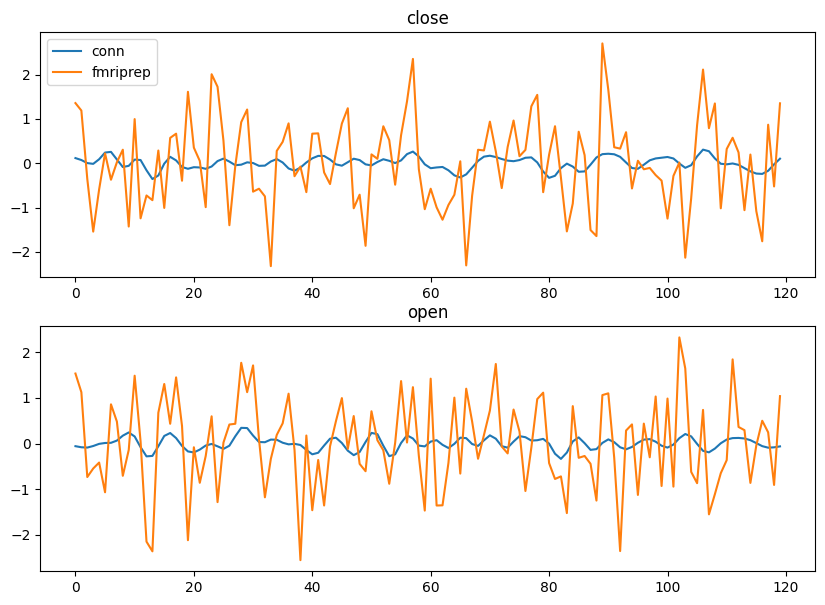

In [15]:
roi_num = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
ax1.plot(ts_close_conn[roi_num], label='conn')
ax1.plot(close_ts[:, roi_num] , label='fmriprep')
ax1.set_title('close')
ax2.plot(ts_open_conn[roi_num])
ax2.plot(open_ts[:, roi_num])
ax2.set_title('open')
ax1.legend();

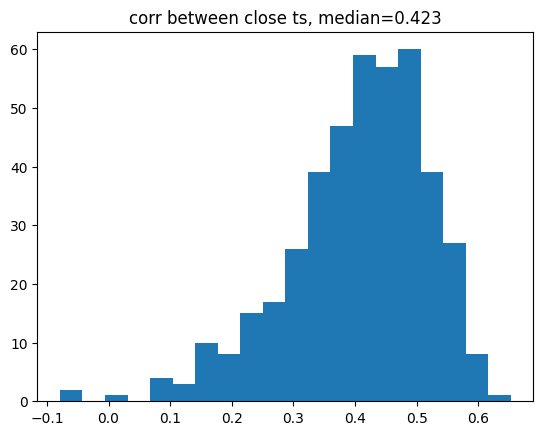

In [16]:
plot_corr_hist(ts_close_conn, close_ts.T, 'corr between close ts')

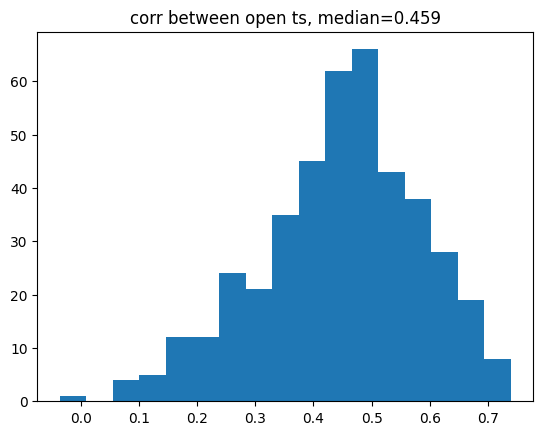

In [17]:
plot_corr_hist(ts_open_conn, open_ts.T, f'corr between open ts')

c:\ProgramData\Anaconda3\envs\nilearn\lib\site-packages\nilearn\plotting\matrix_plotting.py:293: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


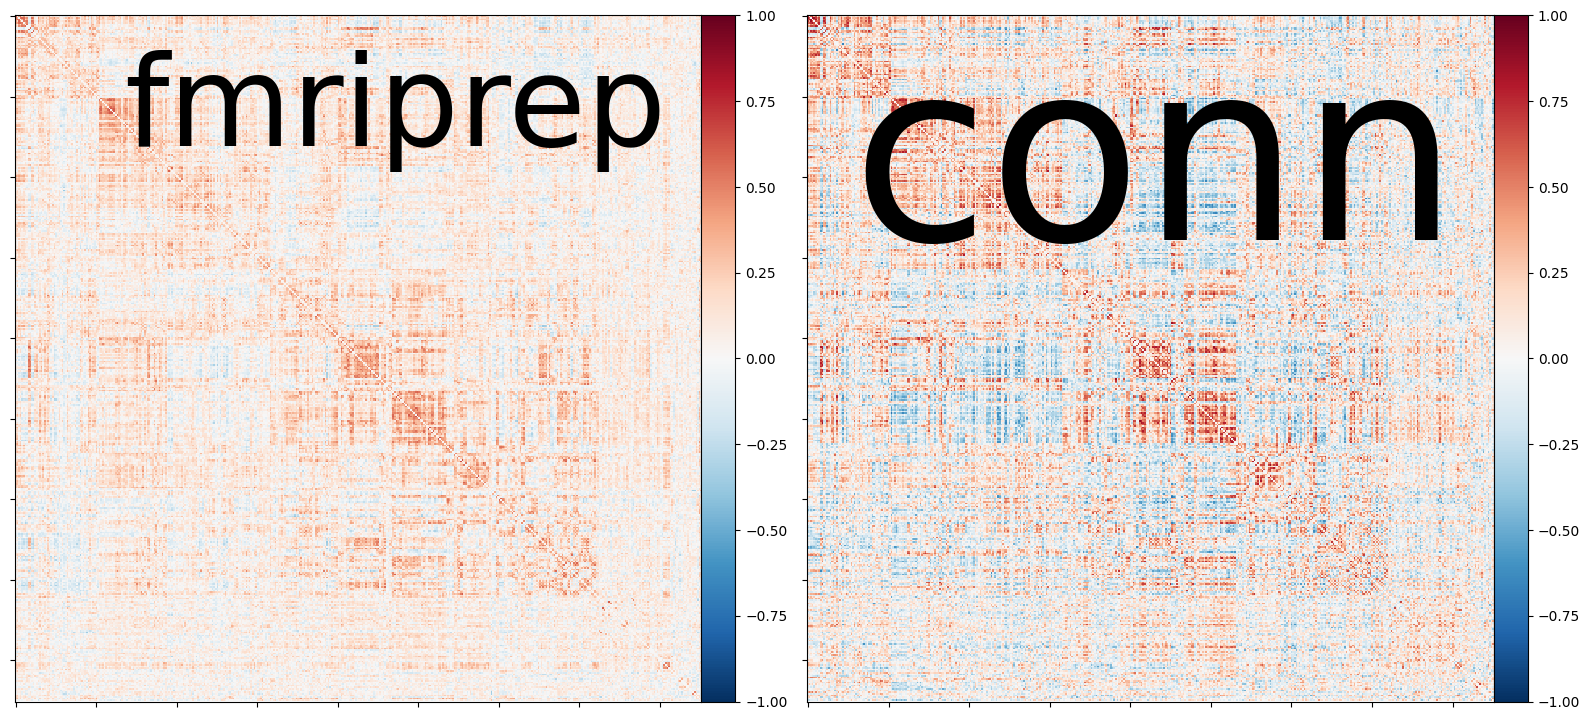

In [18]:
# close

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plotting.plot_matrix(
    reorder_matrix(correlation_matrix[0], roi.ID-1),
    labels=None,
    vmax=1,
    vmin=-1,
    title="fmriprep",
    reorder=False, axes=ax1)

plotting.plot_matrix(
    reorder_matrix(np.tanh(close_z), roi.ID-1),
    labels=None,
    vmax=1,
    vmin=-1,
    title="conn", 
    reorder=False, axes=ax2);


c:\ProgramData\Anaconda3\envs\nilearn\lib\site-packages\nilearn\plotting\matrix_plotting.py:293: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


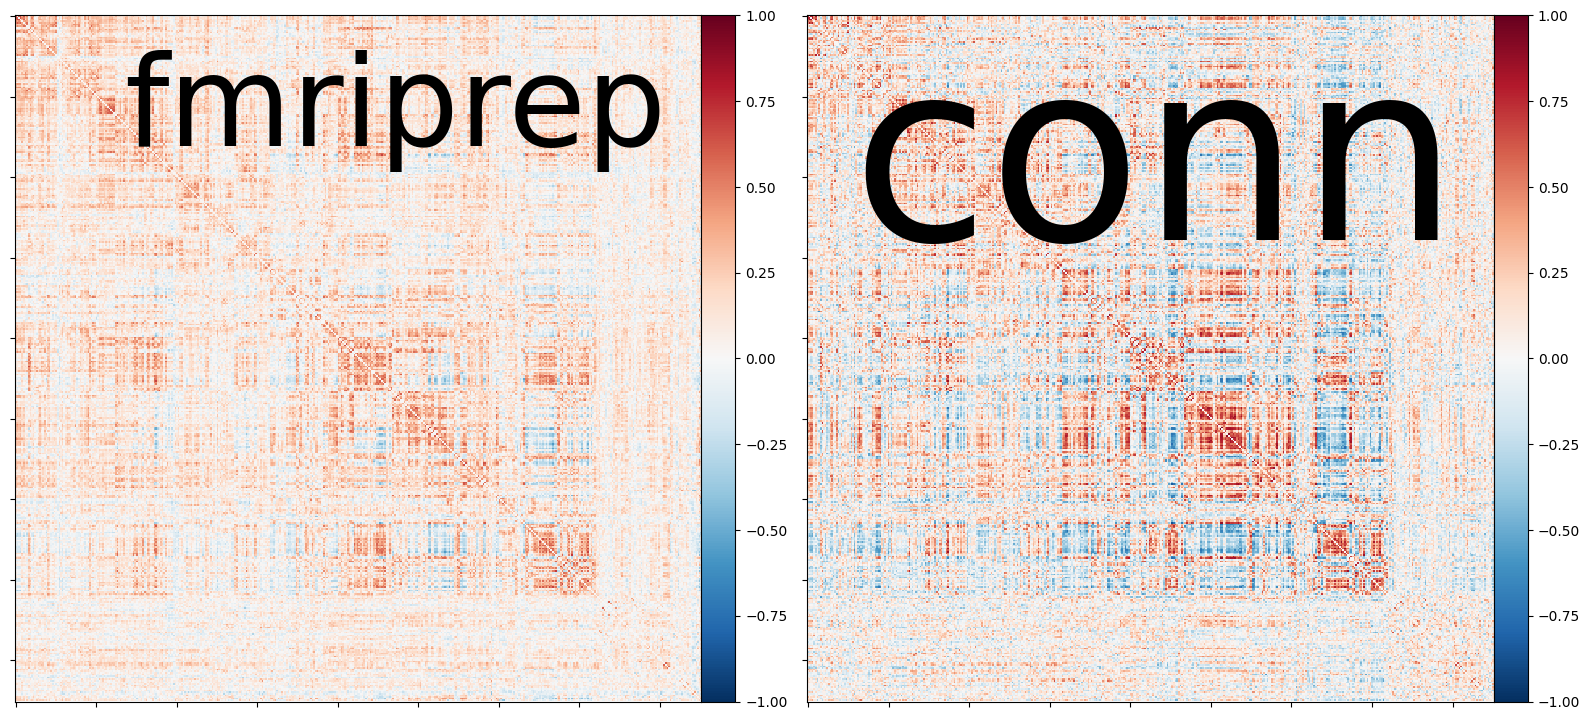

In [19]:
# open

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plotting.plot_matrix(
    reorder_matrix(correlation_matrix[1], roi.ID-1),
    labels=None,
    vmax=1,
    vmin=-1,
    title="fmriprep",
    reorder=False, axes=ax1)

plotting.plot_matrix(
    reorder_matrix(np.tanh(open_z), roi.ID-1),
    labels=None,
    vmax=1,
    vmin=-1,
    title="conn", 
    reorder=False, axes=ax2);

In [20]:
np.corrcoef(close_z.flatten(), correlation_matrix[0].flatten())[0, 1]

0.533871628996584